# Medicare Claims Data Analysis Project Goals:

* Create and call at least 3 functions, at least one of which must return a value that is used

* Calculate and display data based on an external factor

* Connect to an external/3rd party API and read data into your app

* Analyze text/data and display information about it (ex: how many words in a paragraph)

* Visualize data in a graph, chart, or other visual representation of data


In [18]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

# pd.set_option('display.max_rows', None)

## Create and call at least 3 functions, at least one of which must return a value that is used
* The below cell will run everything we need to format and consolidate our data that we will be using for all three years.
* The functions will be used to: 
    * make the API call 
    * add and format columns from existing data
    * aggregate data by HCPCS Code (so there are no duplicates in each year) 
    * create two "delta" dataframes that track year-to-year changes
    * help format the delta dataframes and master dataframe by reinserting the index and recovering the "HCPCS Code" column.
    
## Calculate and display data based on an external factor.
* "add_totals_columns" function makes use of calculations within the returned data. For example, the total billed amount of a procedure is calculated by multiplying the "number of services" value by the "average medicare allowed amount" originally present in the data. 
* Three such calculations are used in this function, and these columns will provide the most useful data for our analysis.

In [19]:
### ALL FUNCTIONS

# Function that will retrieve raw data that can be read into dataframe.
def get_api_data(url):
    request = requests.get(url)
    return request.content


# Function that will add columns needed for each dataframe that can be used for further analysis.
def add_totals_columns (df, year):
    df["total_billed_amount"] = df["number_of_services"] * df["average_medicare_allowed_amount"]
    df["total_amount_paid"] = df["number_of_services"] * df["average_medicare_payment_amount"]
    df["total_cost_to_patient"] = df["number_of_services"] * (df["average_medicare_allowed_amount"] - df["average_medicare_payment_amount"])
    return df


# Function that will aggregate data, allowing combination of data by HCPCS code to eliminate multiple codes in data set.
def aggregate_data(df):
    aggregation_instructions = {'hcpcs_description': 'first',
                            'hcpcs_drug_indicator': 'first',
                            'number_of_providers': 'sum',
                            'number_of_services' : 'sum',
                            'number_of_distinct_medicare_beneficiary_per_day_services': 'sum',
                            'average_submitted_charge_amount': 'mean',
                            'average_medicare_allowed_amount': 'mean',
                            'average_medicare_payment_amount': 'mean',
                            'total_billed_amount': 'sum',
                            'total_amount_paid': 'sum',
                            'total_cost_to_patient': 'sum',                         
                           }
    return df.groupby('hcpcs_code').aggregate(aggregation_instructions)


# Function using outer join to gather information regarding changes (delta) from year to year.
# fillna() method allows us to fill in all "NaN" or "<NA>" data so we can add/subtract data properly.    
def get_delta(df1, df2):
    join = pd.merge(df1, df2, how = 'outer', on=['hcpcs_code'])

    join = join[['number_of_services_x', 
                 'total_billed_amount_x', 
                 'total_amount_paid_x',
                 'total_cost_to_patient_x',
                 'number_of_services_y',
                 'total_billed_amount_y',
                 'total_amount_paid_y',
                 'total_cost_to_patient_y'
                ]].fillna(0)

    join['number_of_services_delta'] = join['number_of_services_x'] - join['number_of_services_y']
    join['total_billed_amount_delta'] = join['total_billed_amount_x'] - join['total_billed_amount_y']
    join['total_amount_paid_delta'] = join['total_amount_paid_x'] - join['total_amount_paid_y']
    join['total_cost_to_patient_delta'] = join['total_cost_to_patient_x'] - join['total_cost_to_patient_y']
                                                                                 
    return join[['number_of_services_delta', 
                 'total_billed_amount_delta', 
                 'total_amount_paid_delta',
                 'total_cost_to_patient_delta'
               ]]


# Function to use after join on HCPCS Codes that will re-establish index for easier slicing while retaining 'hcpcs_code' column.
def get_new_index(df):
    codes = df.index
    codes = codes.astype(int)
    index = np.array(list(range(0,len(df))))
    new_df = df.set_index(index)
    new_df.insert(0, 'hcpcs_code', codes)
    
    return new_df




## Connect to an external/3rd party API and read data into your app

### Medicare Data Set of Surgical HCPCS Codes Reported on Claims, 2015-2017

* CMS API Endpoint, 2015: https://data.cms.gov/resource/uqfq-w9cg.json
* CMS API Endpoint, 2016: https://data.cms.gov/resource/jtra-d83c.json
* CMS API Endpoint, 2017: https://data.cms.gov/resource/2zuc-y5mm.json
* API Documentation, 2015: https://dev.socrata.com/foundry/data.cms.gov/uqfq-w9cg
* API Documentation, 2016: https://dev.socrata.com/foundry/data.cms.gov/jtra-d83c
* API Documentation, 2017: https://dev.socrata.com/foundry/data.cms.gov/2zuc-y5mm
* Was able to use documentation to format the below SoQL queries within my URLs to return a specific set of codes (10004 and 69990 - Surgical Codes).

In [20]:
# API Calls
df_2015 = add_totals_columns(pd.read_json(get_api_data("https://data.cms.gov/resource/uqfq-w9cg.json?$where=hcpcs_code between '10004' and '69990'&$limit=10000 ")).convert_dtypes(), 2015)
df_2016 = add_totals_columns(pd.read_json(get_api_data("https://data.cms.gov/resource/jtra-d83c.json?$where=hcpcs_code between '10004' and '69990'&$limit=10000 ")).convert_dtypes(), 2016)
df_2017 = add_totals_columns(pd.read_json(get_api_data("https://data.cms.gov/resource/2zuc-y5mm.json?$where=hcpcs_code between '10004' and '69990'&$limit=10000 ")).convert_dtypes(), 2017)

In [21]:
# Using Functions to return main dataframe with all data and "delta" dataframes of year-to-year changes.

df_2015_agg = aggregate_data(df_2015)
df_2016_agg = aggregate_data(df_2016)
df_2017_agg = aggregate_data(df_2017)

d2016 = get_delta(df_2016_agg, df_2015_agg)
delta2016 = get_new_index(d2016)

d2017 = get_delta(df_2017_agg, df_2016_agg)
delta2017 = get_new_index(d2017)


frames = [df_2015_agg, df_2016_agg, df_2017_agg]
df = reduce(lambda  left,right: pd.merge(left,right,on=['hcpcs_code'], how='outer'), frames)
df = get_new_index(df)

In [22]:
# Formatting main dataframe columns for easier use.

descriptions = df['hcpcs_description_y']
descriptions2 = df['hcpcs_description']
df['hcpcs_description_x'] = df['hcpcs_description_x'].fillna(descriptions)
df['hcpcs_description_x'] = df['hcpcs_description_x'].fillna(descriptions2)

drug_indicator = df['hcpcs_drug_indicator_y']
drug_indicator2 = df['hcpcs_drug_indicator']
df['hcpcs_drug_indicator_x'] = df['hcpcs_drug_indicator_x'].fillna(drug_indicator)
df['hcpcs_drug_indicator_x'] = df['hcpcs_drug_indicator_x'].fillna(drug_indicator2)

df = df.drop([
    'number_of_distinct_medicare_beneficiary_per_day_services_x',
    'average_submitted_charge_amount_x',
    'hcpcs_description_y',
    'hcpcs_drug_indicator_y',
    'number_of_distinct_medicare_beneficiary_per_day_services_y',
    'average_submitted_charge_amount_y',
    'hcpcs_description',
    'hcpcs_drug_indicator',
    'number_of_distinct_medicare_beneficiary_per_day_services',
    'average_submitted_charge_amount'    
], axis=1)

df = df.rename(columns = {
    'hcpcs_code': "HCPCS Code",
    'hcpcs_description_x': 'Code Description',
    'hcpcs_drug_indicator_x': 'Drug Indicator',
    'number_of_providers_x': 'Number of Providers - 2015',
    'number_of_services_x': 'Number of Services - 2015',
    'average_medicare_allowed_amount_x': 'Average Allowed Amount - 2015',
    'average_medicare_payment_amount_x': 'Average Payment Amount - 2015',
    'total_billed_amount_x': 'Total Billed Amount - 2015',
    'total_amount_paid_x': 'Total Amount Paid - 2015',
    'total_cost_to_patient_x': 'Total Cost to Patient - 2015',
    'number_of_providers_y': 'Number of Providers - 2016',
    'number_of_services_y': 'Number of Services - 2016',
    'average_medicare_allowed_amount_y': 'Average Allowed Amount - 2016',
    'average_medicare_payment_amount_y': 'Average Payment Amount - 2016',
    'total_billed_amount_y': 'Total Billed Amount - 2016',
    'total_amount_paid_y': 'Total Amount Paid - 2016',
    'total_cost_to_patient_y': 'Total Cost to Patient - 2016',
    'number_of_providers': 'Number of Providers - 2017',
    'number_of_services': 'Number of Services - 2017', 
    'average_medicare_allowed_amount': 'Average Allowed Amount - 2017',
    'average_medicare_payment_amount': 'Average Payment Amount - 2017',
    'total_billed_amount': 'Total Billed Amount - 2017',
    'total_amount_paid': 'Total Amount Paid - 2017',
    'total_cost_to_patient': 'Total Cost to Patient - 2017'
})

In [23]:
df

,HCPCS Code,Code Description,Drug Indicator,Number of Providers - 2015,Number of Services - 2015,Average Allowed Amount - 2015,Average Payment Amount - 2015,Total Billed Amount - 2015,Total Amount Paid - 2015,Total Cost to Patient - 2015,...,Total Billed Amount - 2016,Total Amount Paid - 2016,Total Cost to Patient - 2016,Number of Providers - 2017,Number of Services - 2017,Average Allowed Amount - 2017,Average Payment Amount - 2017,Total Billed Amount - 2017,Total Amount Paid - 2017,Total Cost to Patient - 2017
0,10021,Fine needle aspiration,N,8601,25636,111.130,84.810,3204764.68,2443985.84,760778.84,...,2584193.88,1953642.90,630550.98,7849,22386,96.035,72.150,2384946.36,1785789.60,599156.76
1,10022,Fine needle aspiration using imaging guidance,N,17387,193350,107.010,81.855,20936649.42,16016399.22,4920250.20,...,19731428.86,15032383.16,4699045.70,17600,185559,103.990,78.825,19426320.90,14725038.57,4701282.33
2,10030,Fluid collection drainage by catheter using im...,N,3797,7715,392.990,304.570,1407628.61,1087745.19,319883.42,...,1580922.56,1220986.74,359935.82,4077,8336,369.765,284.210,1537535.79,1185857.26,351678.53
3,10040,Acne surgery,N,4649,34267,83.250,61.515,2901532.70,2130371.68,771161.02,...,3149704.92,2287396.80,862308.12,5125,38263,84.115,61.445,3268558.75,2353507.73,915051.02
4,10060,Drainage of abscess,N,114272,431013,103.665,76.390,47923426.85,35097289.21,12826137.64,...,46700842.98,33844982.62,12855860.36,114746,406457,103.465,75.050,45155158.28,32289942.70,12865215.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5244,62326,Insertion of indwelling catheter and administr...,N,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3148,7838,123.225,93.790,809781.35,624155.62,185625.73
5245,62327,Insertion of indwelling catheter and administr...,N,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,649,2731,184.160,138.530,453624.92,342148.55,111476.37
5246,62380,Decompression of spinal cord and/or nerve root...,N,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,83,382,1944.140,1516.170,742661.48,579176.94,163484.54
5247,63610,Stereotactic stimulation of spinal cord throug...,N,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3,12,459.900,355.000,5518.80,4260.00,1258.80


## Analyze text/data, display information and visualize data

### What questions can I use this data set to answer?

* What surgical procedures were most common in from 2015-2017?
* What surgical procedures, overall, cost Medicare the most?
* What procedures were least covered (i.e. where discrepancy between charges and amount paid was greatest).
* What types of procedures are most common (can organize by specialty or by surgery method, etc.)
* What health problems does this analysis bring up and how can we solve them?

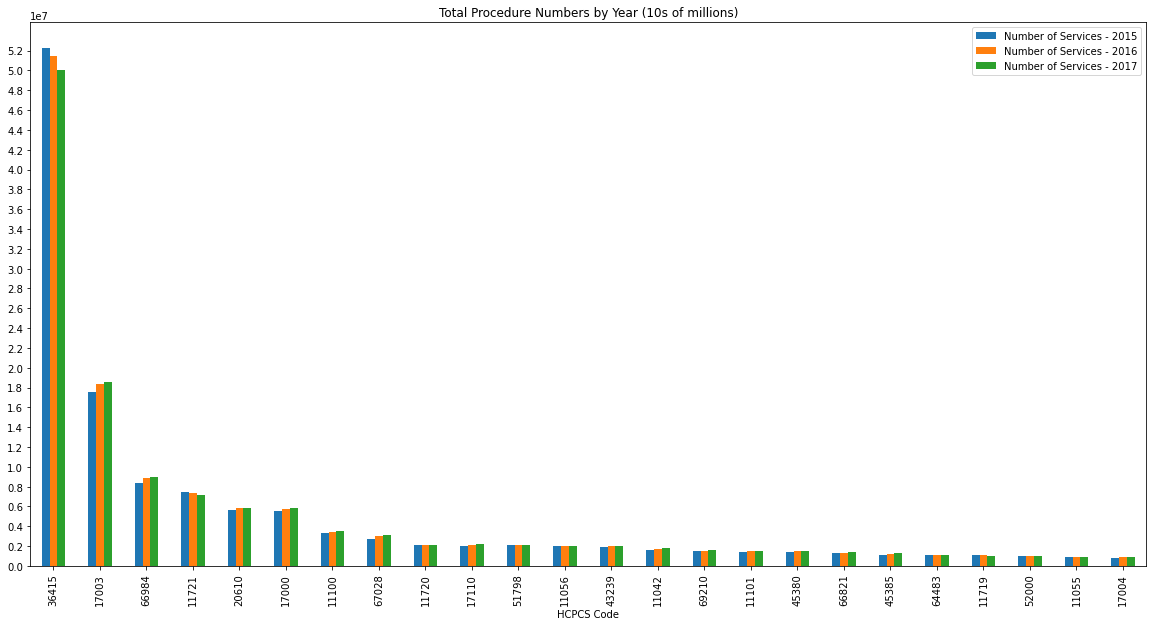

In [62]:
# What surgical procedures were most common from 2015-2017?
df_by_count = df
df_by_count_services = df_by_count [[
    'Number of Services - 2015',
    'Number of Services - 2016',
    'Number of Services - 2017',
]].fillna(0)

df_by_count[['Number of Services - 2015',
             'Number of Services - 2016',
             'Number of Services - 2017'
            ]] = df_by_count_services[[
    'Number of Services - 2015',
    'Number of Services - 2016',
    'Number of Services - 2017'
]] 

df_by_count['Total Number of Services'] = (df_by_count['Number of Services - 2015'] + df_by_count['Number of Services - 2016'] + df_by_count['Number of Services - 2017'])

df_by_count = df_by_count.sort_values(by=['Total Number of Services'], ascending=False)[['HCPCS Code', 'Code Description', 'Number of Services - 2015', 'Number of Services - 2016', 'Number of Services - 2017']]

y_axis = np.arange(0,52000001, 2000000)
df_by_count[0:24].plot.bar(x = "HCPCS Code", title = "Total Procedure Numbers by Year (10s of millions)", yticks = y_axis, figsize = (20, 10))









,HCPCS Code,Code Description,Total Amount Paid - 2015,Total Amount Paid - 2016,Total Amount Paid - 2017
4797,66984,Removal of cataract with insertion of lens,1.664576e+09,1.735582e+09,1.751801e+09
1388,27447,Repair of knee joint,3.196110e+08,3.419831e+08,3.487564e+08
320,17311,Removal and microscopic examination of growth ...,2.847425e+08,3.088702e+08,3.212190e+08
3293,45385,Removal of polyps or growths of large bowel us...,3.061109e+08,2.983536e+08,3.217216e+08
2992,43239,"Biopsy of the esophagus, stomach, and/or upper...",2.633978e+08,2.658228e+08,2.503180e+08
415,20610,Aspiration and/or injection of large joint or ...,2.483302e+08,2.538874e+08,2.558095e+08
3289,45380,Biopsy of large bowel using an endoscope,2.800815e+08,2.514522e+08,2.658638e+08
4807,67028,Injection of drug into eye,2.210510e+08,2.393873e+08,2.511081e+08
91,11721,Removal of tissue from 6 or more finger or toe...,2.374737e+08,2.308787e+08,2.239582e+08


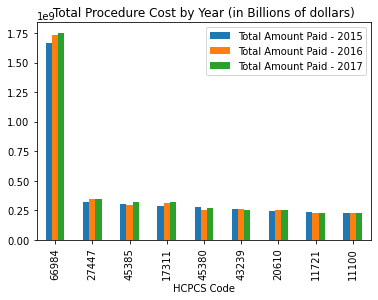

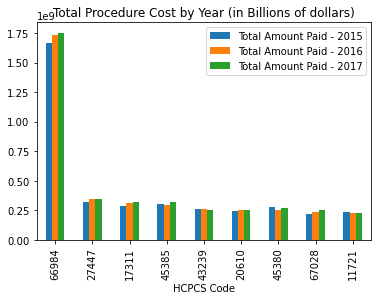

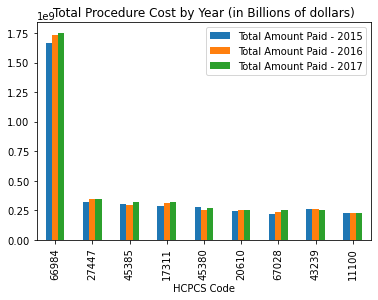

In [7]:
# What surgical procedures, overall, cost Medicare the most?
df_cost_2015 = df.sort_values(by=['Total Amount Paid - 2015'], ascending=False)[['HCPCS Code', 'Code Description', 'Total Amount Paid - 2015', 'Total Amount Paid - 2016', 'Total Amount Paid - 2017']]
df_cost_2016 = df.sort_values(by=['Total Amount Paid - 2016'], ascending=False)[['HCPCS Code', 'Code Description', 'Total Amount Paid - 2015', 'Total Amount Paid - 2016', 'Total Amount Paid - 2017']]
df_cost_2017 = df.sort_values(by=['Total Amount Paid - 2017'], ascending=False)[['HCPCS Code', 'Code Description', 'Total Amount Paid - 2015', 'Total Amount Paid - 2016', 'Total Amount Paid - 2017']]

df_cost_2015[0:9].plot.bar(x = "HCPCS Code", title = "Total Procedure Cost by Year (in Billions of dollars)")
df_cost_2016[0:9].plot.bar(x = "HCPCS Code", title = "Total Procedure Cost by Year (in Billions of dollars)")
df_cost_2017[0:9].plot.bar(x = "HCPCS Code", title = "Total Procedure Cost by Year (in Billions of dollars)")

df_cost_2016[0:9]

In [8]:
df[4797:4798]
df[1388:1389]

,HCPCS Code,Code Description,hcpcs_drug_indicator_x,Number of Providers - 2015,Number of Services - 2015,Average Allowed Amount - 2015,Average Payment Amount - 2015,Total Billed Amount - 2015,Total Amount Paid - 2015,Total Cost to Patient - 2015,...,Total Amount Paid - 2016,Total Cost to Patient - 2016,hcpcs_drug_indicator,Number of Providers - 2017,Number of Services - 2017,Average Allowed Amount - 2017,Average Payment Amount - 2017,Total Billed Amount - 2017,Total Amount Paid - 2017,Total Cost to Patient - 2017
1388,27447,Repair of knee joint,N,19181,439245,947.36,733.485,4.123981e+08,319611027.7,92787111.86,...,3.419831e+08,99504342.4,N,19435,487562,632.17,487.785,4.501075e+08,3.487564e+08,1.013511e+08


In [ ]:
# What procedures were least covered (i.e. where discrepancy between charges and amount paid was greatest).


In [ ]:
# What types of procedures are most common (can organize by specialty or by surgery method, etc.)


In [ ]:
# What health problems does this analysis bring up and how can we solve them?